In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logomaker as lm
import re
import mplcursors
import utils
from matplotlib.gridspec import GridSpec

# Useful variables
e = np.exp(1)
idx = pd.IndexSlice
_ = np.newaxis

# For displaying figures
%matplotlib inline

In [2]:
# Remove existing pdf files
!rm *.pdf

In [3]:
# Set figure style
style_file_name = f'fig.style'
s = """
axes.linewidth:     1.0     # edge linewidth
font.size:          7.0
axes.labelsize:     7.0  # fontsize of the x any y labels
xtick.labelsize:    7.0  # fontsize of the tick labels
ytick.labelsize:    7.0  # fontsize of the tick labels
legend.fontsize:      7.0
legend.borderpad:     0.5  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
axes.labelpad:      1.0     # space between label and axis
figure.dpi: 600
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)

### Biophysical model

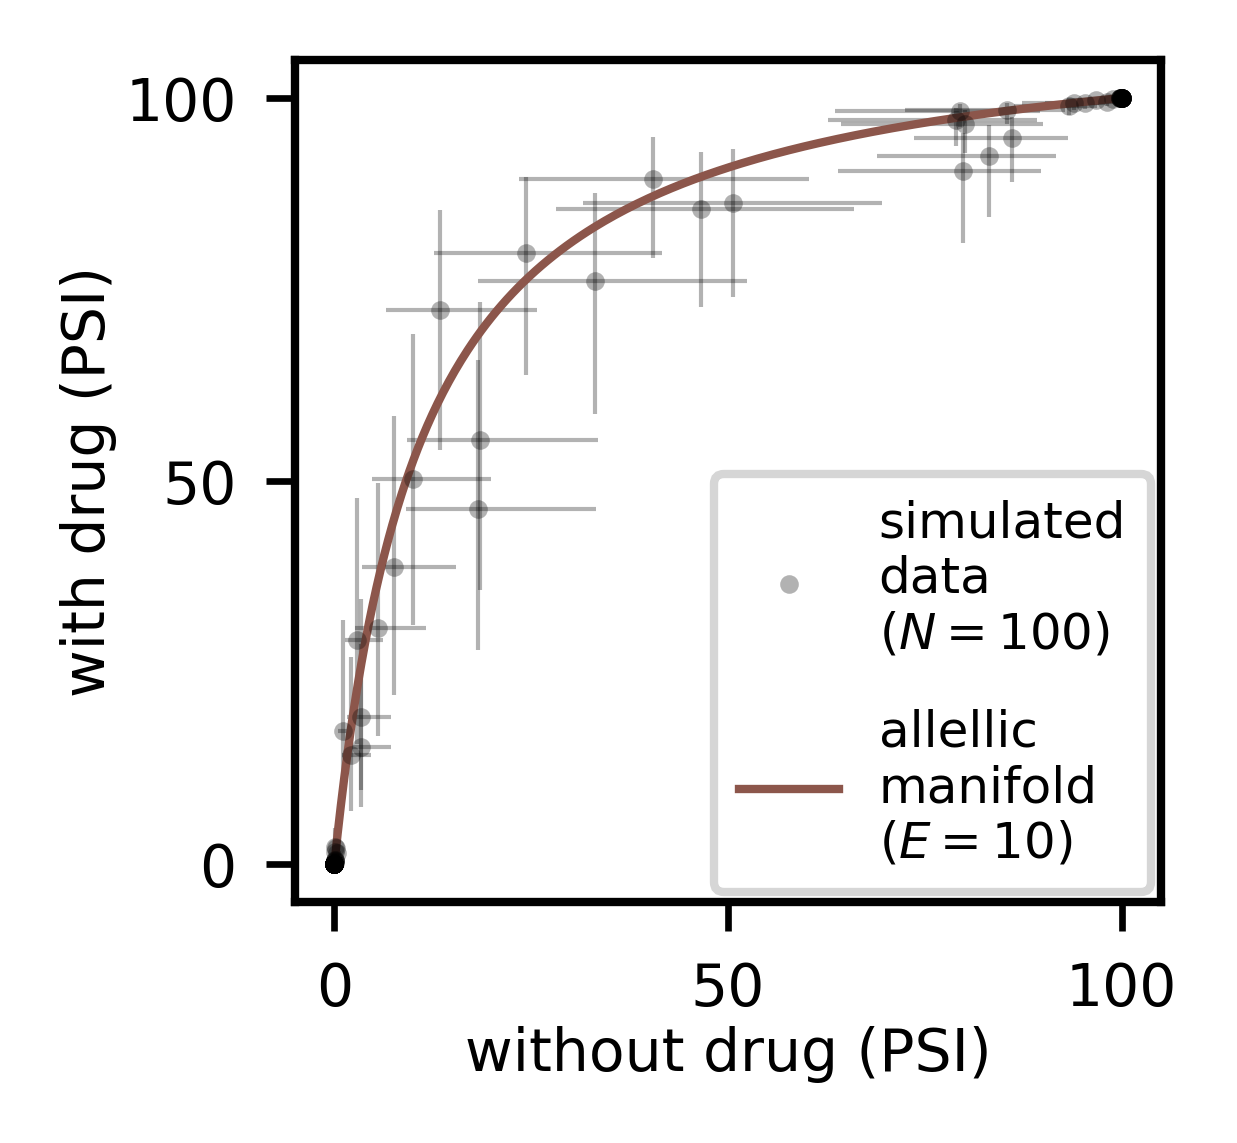

In [4]:
fig, ax = plt.subplots(1,1,figsize=[2.05,1.9])
lr_grid = np.linspace(-10,10,1000)
R_grid = np.exp(lr_grid)
ticks = [0, 50, 100]
lim = [-5, 105]
E = 10

x_grid = 100*R_grid/(1+R_grid)
y_grid = 100*(E*R_grid)/(1 + E*R_grid)

np.random.seed(0)
N = 100
lr_data = np.random.uniform(-25, 15, N)
R_data = np.exp(lr_data)

sigma=.4
eta1 = np.exp(sigma*np.random.randn(N))
eta1_lo = eta1*np.exp(-2*sigma)
eta1_hi = eta1*np.exp(+2*sigma)

eta2 = np.exp(sigma*np.random.randn(N))
eta2_lo = eta2*np.exp(-2*sigma)
eta2_hi = eta2*np.exp(+2*sigma)

x_data = 100*R_data*eta1/(1+R_data*eta1)
dx_lo = x_data - 100*R_data*eta1_lo/(1+R_data*eta1_lo)
dx_hi = 100*R_data*eta1_hi/(1+R_data*eta1_hi) - x_data

y_data = 100*(E*R_data*eta2)/(1 + E*R_data*eta2)
dy_lo = y_data - 100*(E*R_data*eta2_lo)/(1 + E*R_data*eta2_lo)
dy_hi = 100*(E*R_data*eta2_hi)/(1 + E*R_data*eta2_hi) - y_data

color = 'C5'
ax.scatter(x_data, y_data, marker='o', linewidth=0, s=5,
        label=f'simulated\ndata\n($N={N}$)', color='k', alpha=.3)
ax.errorbar(x=x_data, y=y_data, xerr=[dx_lo, dx_hi], yerr=[dy_lo, dy_hi], 
            color='k', linewidth=0, elinewidth=.5, alpha=.3, zorder=-100)
ax.plot(x_grid, y_grid, markersize=0, linewidth=1, 
        label=f'allellic\nmanifold\n($E={E}$)', color=color, zorder=-100)

# Plot points
ax.set(
    xticks=ticks,
    yticks=ticks,
    xlabel='without drug (PSI)',
    ylabel='with drug (PSI)',
    xlim=lim,
    ylim=lim)
ax.patch.set_facecolor('white')
fig.patch.set_alpha(0)
ax.legend(loc=4, fontsize=6, labelspacing=1)
fig.tight_layout(pad=1)

fig.savefig(f'fig2C.pdf')

### Load results of rMATS analysis

In [5]:
# Load exon data
rmats_df = pd.read_csv('../data/rna-seq/rmats_results.csv.gz', index_col=0)

# Keep only GT 5'ss
ix = [s[4:6]=='GT' for s in rmats_df['5ss']]
rmats_df = rmats_df[ix]

# Replace T->U
rmats_df['5ss'] = [s.replace('T','U') for s in rmats_df['5ss']]

# Add slash
rmats_df['5ss'] = [s[:4]+'/'+s[4:] for s in rmats_df['5ss']] 

print(len(rmats_df))
rmats_df.head()

235711


,DMSO_PSI,DMSO_PSI_q0.025,DMSO_PSI_q0.975,Risdiplam_PSI,Risdiplam_PSI_q0.025,Risdiplam_PSI_q0.975,Branaplam_PSI,Branaplam_PSI_q0.025,Branaplam_PSI_q0.975,5ss
event_id,,,,,,,,,,
"chr21:46635673-46635763,46636438-46636547,46636895-46636990+",0.125568,0.103237,0.151840,0.103712,0.085447,0.125584,0.207828,0.176884,0.241491,CCAG/GUAGGG
"chr21:46636895-46636990,46643534-46643639,46644305-46644488+",0.998346,0.993276,0.999849,0.999851,0.999267,1.000000,0.999870,0.999272,1.000000,CCAG/GUAGCC
"chr21:46636895-46636990,46644305-46644488,46648457-46648538+",0.995459,0.976756,0.999671,0.995913,0.983073,0.999843,0.998385,0.992661,0.999950,UCUG/GUAUUG
"chr21:46648457-46648619,46649574-46649739,46660832-46660962+",0.996505,0.984109,0.999766,0.999742,0.998499,0.999999,0.999743,0.998568,0.999999,GCUG/GUGAGG
"chr21:46648457-46648619,46649574-46649739,46664294-46664473+",0.995359,0.970740,0.999843,0.997431,0.991316,0.999983,0.998480,0.994788,0.999990,GCUG/GUGAGG


In [6]:
# Get number of occurances of each unique 5'ss
ss_counts_df = rmats_df['5ss'].value_counts().to_frame()
ss_counts_df.columns = ['ct']
ss_counts_df.index.name = '5ss'

print(f'Total distinct 5ss: {len(ss_counts_df):,}')
print(f'Num exons: {sum(ss_counts_df["ct"]):,}')

ss_counts_df

Total distinct 5ss: 13,431
Num exons: 235,711


,ct
5ss,
ACAG/GUGUGA,1295
ACAG/GUGUGU,1105
ACAG/GUAUGA,736
AAAG/GUAAGA,681
ACAG/GUGCGU,668
...,...
UGCA/GUCUUC,1
UUGG/GUUUGA,1
UUCC/GUAUCC,1


RNA-seq was perform in HeLa cells treated with 140 nM risdiplam, 70 nM branaplam, or DMSO. Five biological replicates were performed for each condition, and sequenced using one run on NextSeq 2000 P3 chip.  A total of **1,442,392,333** reads were obtained. These data were then analyzed using rMATs, which provided PSI values and corresponding 95% posterior credible intervals in all three conditions for distinct **235,711** distinct exons having 5ss with GT at +1 and +2. Among these exons were **13,431** distinct 10 nt 5'ss sequences. Other alternative splicing events (cassette exons at non-GT splice sites, alternative 5'ss, alternative 3'ss, intron retention, etc.) were not analyzed.

### Load results of allelic manifold fitting

In [7]:
# Load results from manifold infernece
manifold_df = pd.read_csv('../data/rna-seq/allelic_manifold_fits.csv.gz', index_col=0)

# Replace T->U
manifold_df.index = [s.replace('T','U') for s in manifold_df.index]

# Keep only 5'ss with GT
ix = np.array([s[4:6]=='GU' for s in manifold_df.index]).astype(bool)
manifold_df = manifold_df[ix]

# Add slash
manifold_df.index = [s[:4]+'/'+s[4:] for s in manifold_df.index]

# Add in counts for each 5'ss
manifold_df = pd.merge(left=manifold_df, left_index=True, right=ss_counts_df, right_index=True)

# Keep only 5ss with ct >= 10
ix = (manifold_df['ct'] >= 10)
manifold_df = manifold_df[ix]

# Define which exons are sensitive to each drug
# (Minimum threshold for activation: 97.5% posterior probability of >= 2-fold activation)
# TODO: change to 95%

min_logE = np.log(2) 
manifold_df['bran_sens'] = (manifold_df['branaplam.beta_2.5'] >= min_logE)
manifold_df['ris_sens'] = (manifold_df['risdiplam.beta_2.5'] >= min_logE)

# Print stats
print(f'Number of 5ss for which allelic manifolds were fit: {len(manifold_df):,}')
min_num_exons = np.min(manifold_df['ct'])
print(f'Minimum number of exons per manifold: {min_num_exons}')

# Preview
manifold_df.head()

Number of 5ss for which allelic manifolds were fit: 2,521
Minimum number of exons per manifold: 10


,branaplam.beta,branaplam.beta_2.5,branaplam.beta_97.5,risdiplam.beta,risdiplam.beta_2.5,risdiplam.beta_97.5,branaplam_phi,risdiplam_phi,branaplam_pred,risdiplam_pred,branaplam_joint_pred,risdiplam_joint_pred,ct,bran_sens,ris_sens
AAAA/GUAAAA,1.437003,0.734307,2.131132,0.508591,-0.229170,1.219584,0.701366,-7.247973,1.148624,0.049703,1.166810,0.079714,26,True,False
AAAA/GUAAAG,0.215219,-0.541009,1.031155,0.725740,-0.096210,1.595419,0.384366,-7.193003,0.948375,0.051375,0.962342,0.084517,12,False,False
AAAA/GUAAAU,0.795931,0.377787,1.245533,0.121753,-0.321763,0.562879,-1.381167,-8.386038,0.250556,0.018106,0.256567,0.029498,61,False,False
AAAA/GUAACA,0.495291,-0.961621,1.856261,0.252730,-1.225416,1.788902,-2.965126,-7.194746,0.369063,0.040582,0.312811,0.025863,10,False,False
AAAA/GUAACU,0.436673,-0.115834,0.999727,-0.020570,-0.620093,0.517752,-5.047659,-8.332812,0.072880,0.014693,0.061259,0.009274,12,False,False


We next used the PSI values provided by rMATS to infer allelic manifolds describing the effect of each treatment (risdiplam or branaplam) relative to DMSO. Specifically, Bayesian inference was used to infer an allelic manifold for each of the 2,521 5'ss sequences that appeared in at least 10 exons identified by rMATS. The results quantify the estimated effect size E, as well as 95% posterior credible intervals for E, for each 5'ss sequence under treatment with either risdiplam or branaplam. 

In [8]:
# Compute number of splice sites that fall within each of the four categories
sensitivity_counts_df = manifold_df[['ris_sens','bran_sens','ct']].copy()
sensitivity_counts_df['num_ss'] = 1
sensitivity_counts_df = sensitivity_counts_df.groupby(['ris_sens','bran_sens']).sum()
sensitivity_counts_df.sort_index(inplace=True, ascending=False)
sensitivity_counts_df.reset_index(inplace=True)

# Show summary stats
print('\nResults for both drugs:')
print(sensitivity_counts_df)

print('\nResults for risidplam only:')
print(sensitivity_counts_df[['ris_sens','ct','num_ss']].groupby('ris_sens').sum().reset_index())

print('\nResults for branaplam only:')
print(sensitivity_counts_df[['bran_sens','ct','num_ss']].groupby('bran_sens').sum().reset_index())


Results for both drugs:
   ris_sens  bran_sens      ct  num_ss
0      True       True    1236      17
1      True      False      42       1
2     False       True    1538      22
3     False      False  189087    2481

Results for risidplam only:
   ris_sens      ct  num_ss
0     False  190625    2503
1      True    1278      18

Results for branaplam only:
   bran_sens      ct  num_ss
0      False  189129    2482
1       True    2774      39


For each drug, we defined a 5'ss as sensitive if the estimated effect of that drug was greater than 2-fold with 97.5% posterior probability. Of the **2,481** distinct 5'ss sequences (in **189,087** exons) identified in our analysis, **18** 5'ss (occuring in **1,278** exons) were sensitive to risdiplam, and **39** 5'ss (in **2,774** exons) were sensitive to branaplam. Of these, **17** 5'ss (in **1,236** exons) were sensitive to both risdiplam and branaplam, **22** 5'ss (in **1,538** exons) were sensitive branaplam but not risdiplam, and only **1** 5'ss (in **42** exons) was sensitive to risdiplam but not branaplam. These results confirm that, at concentrations that produce similar effects on SMN2 exon 7, branaplam has less 5'ss specificity than risdiplam. 

In [9]:
# Filter based on errorbars
err_threshold = 100
filter_ix = (manifold_df['risdiplam.beta_97.5'] - manifold_df['risdiplam.beta_2.5'] < np.log(err_threshold)) & \
            (manifold_df['branaplam.beta_97.5'] - manifold_df['branaplam.beta_2.5'] < np.log(err_threshold))
print(f'err_threshold = {err_threshold}; filtering out {sum(~filter_ix)} 5ss')
sites = manifold_df.index.values

print(sum(filter_ix))

err_threshold = 100; filtering out 2 5ss
2519


In [10]:
ris_min_motif="ANGA/GUADGN"
hyp_min_motif="RAGA/GURNGN"
hyp_minstar_motif="NAGA/GURNGN"
ris_max_motif="ANGA/GUHDNN"
hyp_max_motif="NANN/GUNNNN"

ris_iupac_motif = 'ANGA/GUHDNN'
hyp_iupac_motif = 'NAGA/GUNNNN'

In [11]:
# Function to draw probability logos
def draw_logo(motif, ax, title, highlight=(), min_motif=None):
    L = 10
    xticklabels = [f'{x:+d}' for x in range(-4,7) if not x==0]
    motif_df = lm.sequence_to_matrix(motif.replace('/','').replace('U','T'), 
                                     is_iupac=True)
    motif_df.columns = list('ACGU')
    logo = lm.Logo(motif_df, 
                   stack_order='fixed',
                   ax=ax, 
                   show_spines=False, 
                   baseline_width=0, 
                   font_name='Arial Rounded MT Bold', 
                   width=.9,
                   fade_probabilities=True)
    ax.set_yticks([])
    ax.set_xticks(range(L))
    ax.set_xticklabels(xticklabels)
    ax.set_title(title, fontsize=7)
    ax.tick_params(length=0, labelsize=6, pad=1)
    ax.axvline(3.5, linestyle=':', linewidth=1, color='k')
    #ax.set_ylim([-.05,1.05])
    
    for pos,base in [(+1,'G'),(+2,'U')]:
        pos = pos+4 if pos < 0 else pos+3
        logo.style_single_glyph(c=base, p=pos, color='k')
        
    # Compute which bases are uncertain
    if min_motif:    
        min_motif_df = lm.sequence_to_matrix(min_motif.replace('/','').replace('U','T'), 
                                             is_iupac=True)
        min_motif_df.columns = list('ACGU')
        for pos in range(L-1):
            for base in list('ACGU'):
                if (motif_df.loc[pos,base]>0) and (min_motif_df.loc[pos,base]==0):
                    logo.style_single_glyph(c=base, p=pos, color='gray', alpha=.5)
    
    for pos, base in highlight:
        pos = pos+4 if pos < 0 else pos+3
        logo.style_single_glyph(c=base, p=pos, color='gray', alpha=.5) 

NNNN/NNNNNN: 2519 5'ss (in 191877 exons)
ANGA/GUHDNN: 19 5'ss (in 1270 exons)
NAGA/GUNNNN: 32 5'ss (in 2550 exons)
AGGA/GUAAGU: 1 5'ss (in 126 exons)
AUGA/GUAAGU: 1 5'ss (in 179 exons)
CAGA/GUAAGG: 1 5'ss (in 74 exons)
UAGA/GUAAGA: 1 5'ss (in 51 exons)


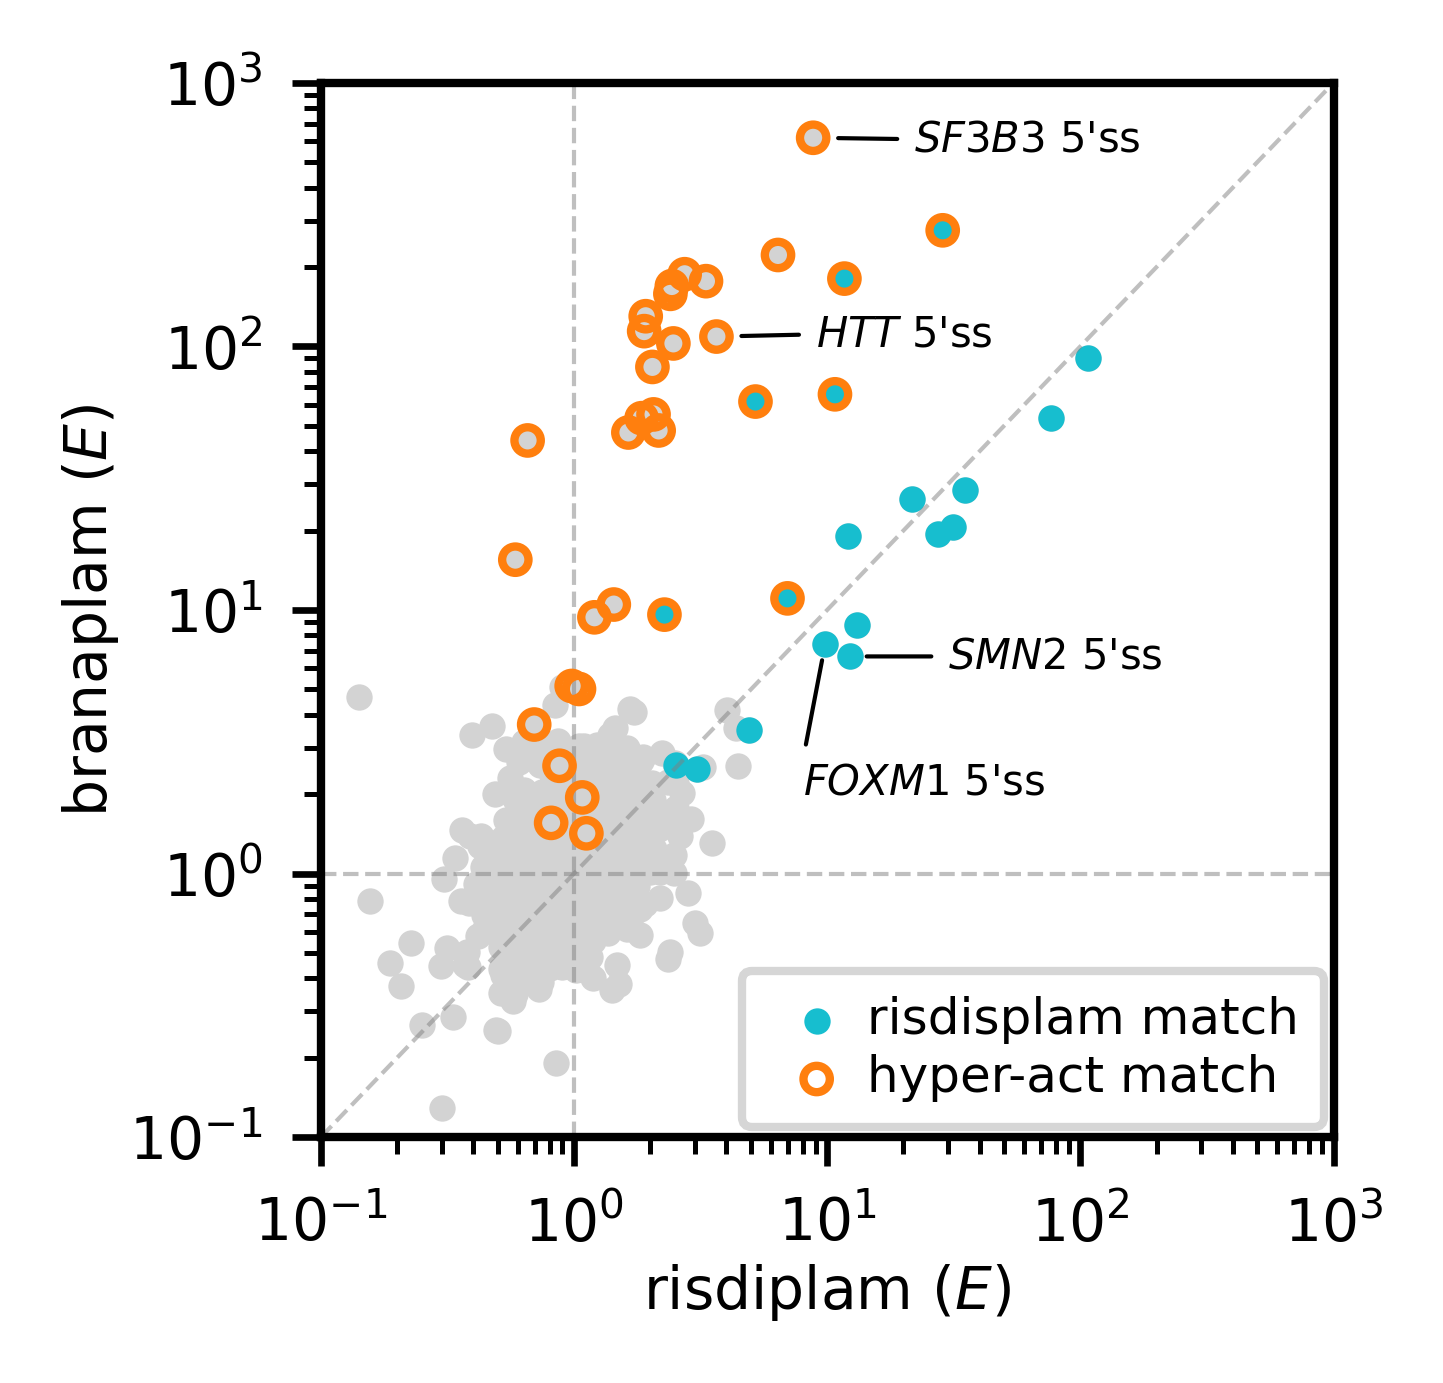

In [12]:
# Show scatter plot of log2 E values
# fig= plt.figure(figsize=[2.3, 2.9])
# #gs = GridSpec(2,1, height_ratios=[.2,1], hspace=.15, left=.21, right=.96)
# gs = GridSpec(2,1, height_ratios=[1, .2], hspace=.60, left=.21, right=.96, bottom=.03, top=.98)

# ax = fig.add_subplot(gs[1,0])
# draw_logo(motif=hyp_iupac_motif, 
#           ax=ax,
#           title='hyper-activation IUPAC motif')

#ax = fig.add_subplot(gs[0,0])

fig, ax = plt.subplots(1,1,figsize=[2.4, 2.3])
x = np.exp(manifold_df['risdiplam.beta'])
y = np.exp(manifold_df['branaplam.beta'])
sites = manifold_df.index.values

# Color datapoints by sequence
s=10
motif_dicts = [
    dict(motif='NNNN/NNNNNN', lw=0, color='lightgray', alpha=1, s=s),
    dict(motif=ris_iupac_motif, lw=0, color='C9', s=s, label='risdisplam match'),
    dict(motif=hyp_iupac_motif, color='C1', lw=1, facecolor='none', marker='o', s=s, label='hyper-act match', zorder=99),
]

for motif_dict in motif_dicts:

    # Pop motif
    motif = motif_dict.pop('motif')
    
    # Get indices of motif-matching sites
    regex = utils.iupac_to_regex(motif)
    ix = np.array([bool(re.match(regex,s)) for s in sites]) & filter_ix
    print(f'{motif}: {sum(ix)} 5\'ss (in {sum(manifold_df["ct"][ix])} exons)')
    
    # Plot dots
    ax.scatter(x[ix], y[ix], **motif_dict)

    

# Place labels at datapoints
exon_dicts = [
    dict(motif='AGGA/GUAAGU', xytext=(30,6), text='$SMN2$ 5\'ss', relpos=[0,.5], shrinkB=2),
    dict(motif='AUGA/GUAAGU', xytext=(8,2), text='$FOXM1$ 5\'ss', relpos=[0,1], shrinkB=2),
    dict(motif='CAGA/GUAAGG', xytext=(9,100), text='$HTT$ 5\'ss', relpos=[0,.5], shrinkB=3),
    dict(motif='UAGA/GUAAGA', xytext=(22,550), text='$SF3B3$ 5\'ss', relpos=[0,.5], shrinkB=3)
]

for exon_dict in exon_dicts:

    # Pop motif
    motif = exon_dict.pop('motif')
    relpos = exon_dict.pop('relpos')
    shrinkB = exon_dict.pop('shrinkB')
    
    # Get indices of motif-matching sites
    regex = utils.iupac_to_regex(motif)
    ix = np.array([bool(re.match(regex,s)) for s in sites]) & filter_ix
    print(f'{motif}: {sum(ix)} 5\'ss (in {sum(manifold_df["ct"][ix])} exons)')
    
    x1=x[ix][0]
    y1=y[ix][0]
    
    ax.annotate(xy=(x1,y1), xycoords='data',
                textcoords='data',
                fontsize=5,
                arrowprops=dict(arrowstyle="-",
                                shrinkA=0,
                                shrinkB=shrinkB,
                                relpos=relpos,
                                linewidth=.5, 
                                connectionstyle="arc3"),
                **exon_dict)
    
lim = (0.1, 1000)
ax.plot(lim, lim, lw=0.5, alpha=0.5, c='grey', linestyle='--')
ax.axvline(1, lw=0.5, alpha=0.5, c='grey', linestyle='--')
ax.axhline(1, lw=0.5, alpha=0.5, c='grey', linestyle='--')
ax.set(xlim=lim, 
       ylim=lim,
       xscale='log',
       yscale='log',
       xlabel='risdiplam ($E$)', 
       ylabel='branaplam ($E$)')
ax.legend(loc=4, fontsize=6, handletextpad=0, borderpad=.5)
utils.add_click_labels(x, y, manifold_df.index, ax)

fig.tight_layout(pad=1)
fig.savefig(f'fig2D.pdf')


In [13]:
# Get fraction of 5'ss with AG vs. GA. 

# All 5'ss
sites = manifold_df.index.values

# Color datapoints by sequence
regex_label_tuples = [
    ('.*', 'all 5\'ss'),
    ('..GA/GU....', 'NNGA/GUNNNN'),
    ('..AG/GU....', 'NNAG/GUNNNN'),
    ('..GA/GUG...', 'NNGA/GUGNNN'),
    ('..GA/GUA...', 'NNGA/GUANNN')
]

for regex, label in regex_label_tuples:
    ix = [bool(re.match(regex,s)) for s in sites]
    num_5ss = sum(manifold_df["ct"][ix])
    num_distinct_seqs = sum(ix)
    all_5ss = sum(manifold_df["ct"])
    print(f'{label}: {num_5ss:,} 5\'ss ({100*num_5ss/all_5ss:.1f}%), ({num_distinct_seqs:,} distinct sequences)')
    
    
# Color datapoints by sequence
regex_label_tuples = [
    ('..GA/GU....', 'NNGA/GUNNNN'),
    ('..GA/GUG...', 'NNGA/GUGNNN'),
    ('..GA/GUA...', 'NNGA/GUANNN')
]
ix_GA = [bool(re.match('..GA/GU....',s)) for s in sites]
GA_5ss = sum(manifold_df["ct"][ix_GA])

print('------')
for regex, label in regex_label_tuples:
    ix = [bool(re.match(regex,s)) for s in sites]
    num_5ss = sum(manifold_df["ct"][ix])
    num_distinct_seqs = sum(ix)
    print(f'{label}: {num_5ss:,} 5\'ss ({100*num_5ss/GA_5ss:.1f}% of GA 5\'ss), ({num_distinct_seqs:,} distinct sequences)')

all 5'ss: 191,903 5'ss (100.0%), (2,521 distinct sequences)
NNGA/GUNNNN: 4,237 5'ss (2.2%), (68 distinct sequences)
NNAG/GUNNNN: 114,327 5'ss (59.6%), (1,227 distinct sequences)
NNGA/GUGNNN: 951 5'ss (0.5%), (18 distinct sequences)
NNGA/GUANNN: 3,286 5'ss (1.7%), (50 distinct sequences)
------
NNGA/GUNNNN: 4,237 5'ss (100.0% of GA 5'ss), (68 distinct sequences)
NNGA/GUGNNN: 951 5'ss (22.4% of GA 5'ss), (18 distinct sequences)
NNGA/GUANNN: 3,286 5'ss (77.6% of GA 5'ss), (50 distinct sequences)


 #### Plot allelic manifolds

In [14]:
# Define functions for plotting allelic manifolds
def logit(p):
    return(np.log(p / (1 - p)))


def invlogit(x):
    return(np.exp(x) / (1 + np.exp(x)))


def _plot_manifold_posterior(axes, seq_ss_beta, drug, color='purple'):
    p1 = np.linspace(1e-4, 1-1e-4, 101)
    x = logit(p1)
    mean = invlogit(x + seq_ss_beta['{}.beta'.format(drug)])
    lower = invlogit(x + seq_ss_beta['{}.beta_2.5'.format(drug)])
    upper = invlogit(x + seq_ss_beta['{}.beta_97.5'.format(drug)])
    
    axes.plot(p1, mean, c=color, lw=1, zorder=-100)
    axes.fill_between(x=p1, y1=lower, y2=upper, color=color, alpha=0.2, lw=0, zorder=-200)

    
def _plot_psi_comparison(axes, psis, treatment, color='purple', alpha=.3, plot_err=False):
    x = 'DMSO_PSI'
    y = '{}_PSI'.format(treatment)
    axes.scatter(psis[x], psis[y], c=color, s=5, alpha=alpha, linewidth=0)
    if plot_err:
        for x1, y1, y2 in zip(psis[x], psis['{}_q0.025'.format(y)],
                              psis['{}_q0.975'.format(y)]):
            axes.plot((x1, x1), (y1, y2), c=color, lw=0.5, alpha=alpha)
        
        for y1, x1, x2 in zip(psis[y], psis['{}_q0.025'.format(x)],
                              psis['{}_q0.975'.format(x)]):
            axes.plot((x1, x2), (y1, y1), c=color, lw=0.5, alpha=alpha)

            
def plot_manifold(axes, seq, drug, seq_ss_beta, ss_psi, color, plot_err=True):
    _plot_manifold_posterior(axes, seq_ss_beta, drug, color=color)
    _plot_psi_comparison(axes, ss_psi, treatment=drug.capitalize(),
                         plot_err=plot_err, color='k')
    axes.plot((0, 1), (0, 1), lw=0.5, linestyle='--', c='grey')
    
    # Add estimated values to the plot
    values = np.array([seq_ss_beta['{}.{}'.format(drug, f)]
              for f in ['beta', 'beta_2.5', 'beta_97.5']])
    values = np.exp(values)
    #text = f'$E={values[0]:.1f}$'
    text = f'$N$: {len(ss_psi)}\n$E$: {values[0]:.1f}\n[{values[1]:.1f},{values[2]:.1f}]'
    axes.text(0.99, 0.01, text, ha='right', va='bottom', fontsize=6)
    
    title = '{}/{}'.format(seq[:4], seq[4:])
    #axes.set(xlim=(0, 1), ylim=(0, 1)) 
    axes.set(xlim=(-.05, 1.05), ylim=(-.05, 1.05)) 


def plot_manifolds(exon_psi, 
                   ss_beta,
                   figsize,
                   sel_seqs,
                   colors,
                   loci,
                   drugs=['risdiplam', 'branaplam'], 
                   plot_err=True):
    ss_beta_dict = ss_beta.to_dict(orient='index')

    fig, subplots = plt.subplots(len(drugs), len(sel_seqs),
                                 figsize=figsize)
    for i, seq in enumerate(sel_seqs):
        # Select 5'ss data        
        seq_ss_beta = ss_beta_dict[seq]
        ss_psi = exon_psi.loc[exon_psi['5ss'] == seq, :]
        color = colors[i]
        locus = loci[i]
        
        # Plot for each drug
        for j, drug in enumerate(drugs):
            ax = subplots[j, i]
            plot_manifold(ax, seq, drug, seq_ss_beta, ss_psi, color=color, plot_err=plot_err)
            
            ax.set_ylabel(f'{drug} (PSI)')
            ax.set_xlabel(f'DMSO (PSI)')
            ax.set_xticks([0,.5,1])
            ax.set_yticks([0,.5,1])
            ax.set_xticklabels([0,50,100])
            ax.set_yticklabels([0,50,100])
            title = f'{seq}\n({locus})'  
            ax.set_title(title, fontsize=7)
            
            if i > 0:
                ax.set(ylabel='', yticklabels=[])
            if j == 0:
                ax.set(xlabel='', xticklabels=[])
            else:
                ax.set_title('')
            ax.tick_params(length=2)

    fig.tight_layout()
    return(fig, subplots)

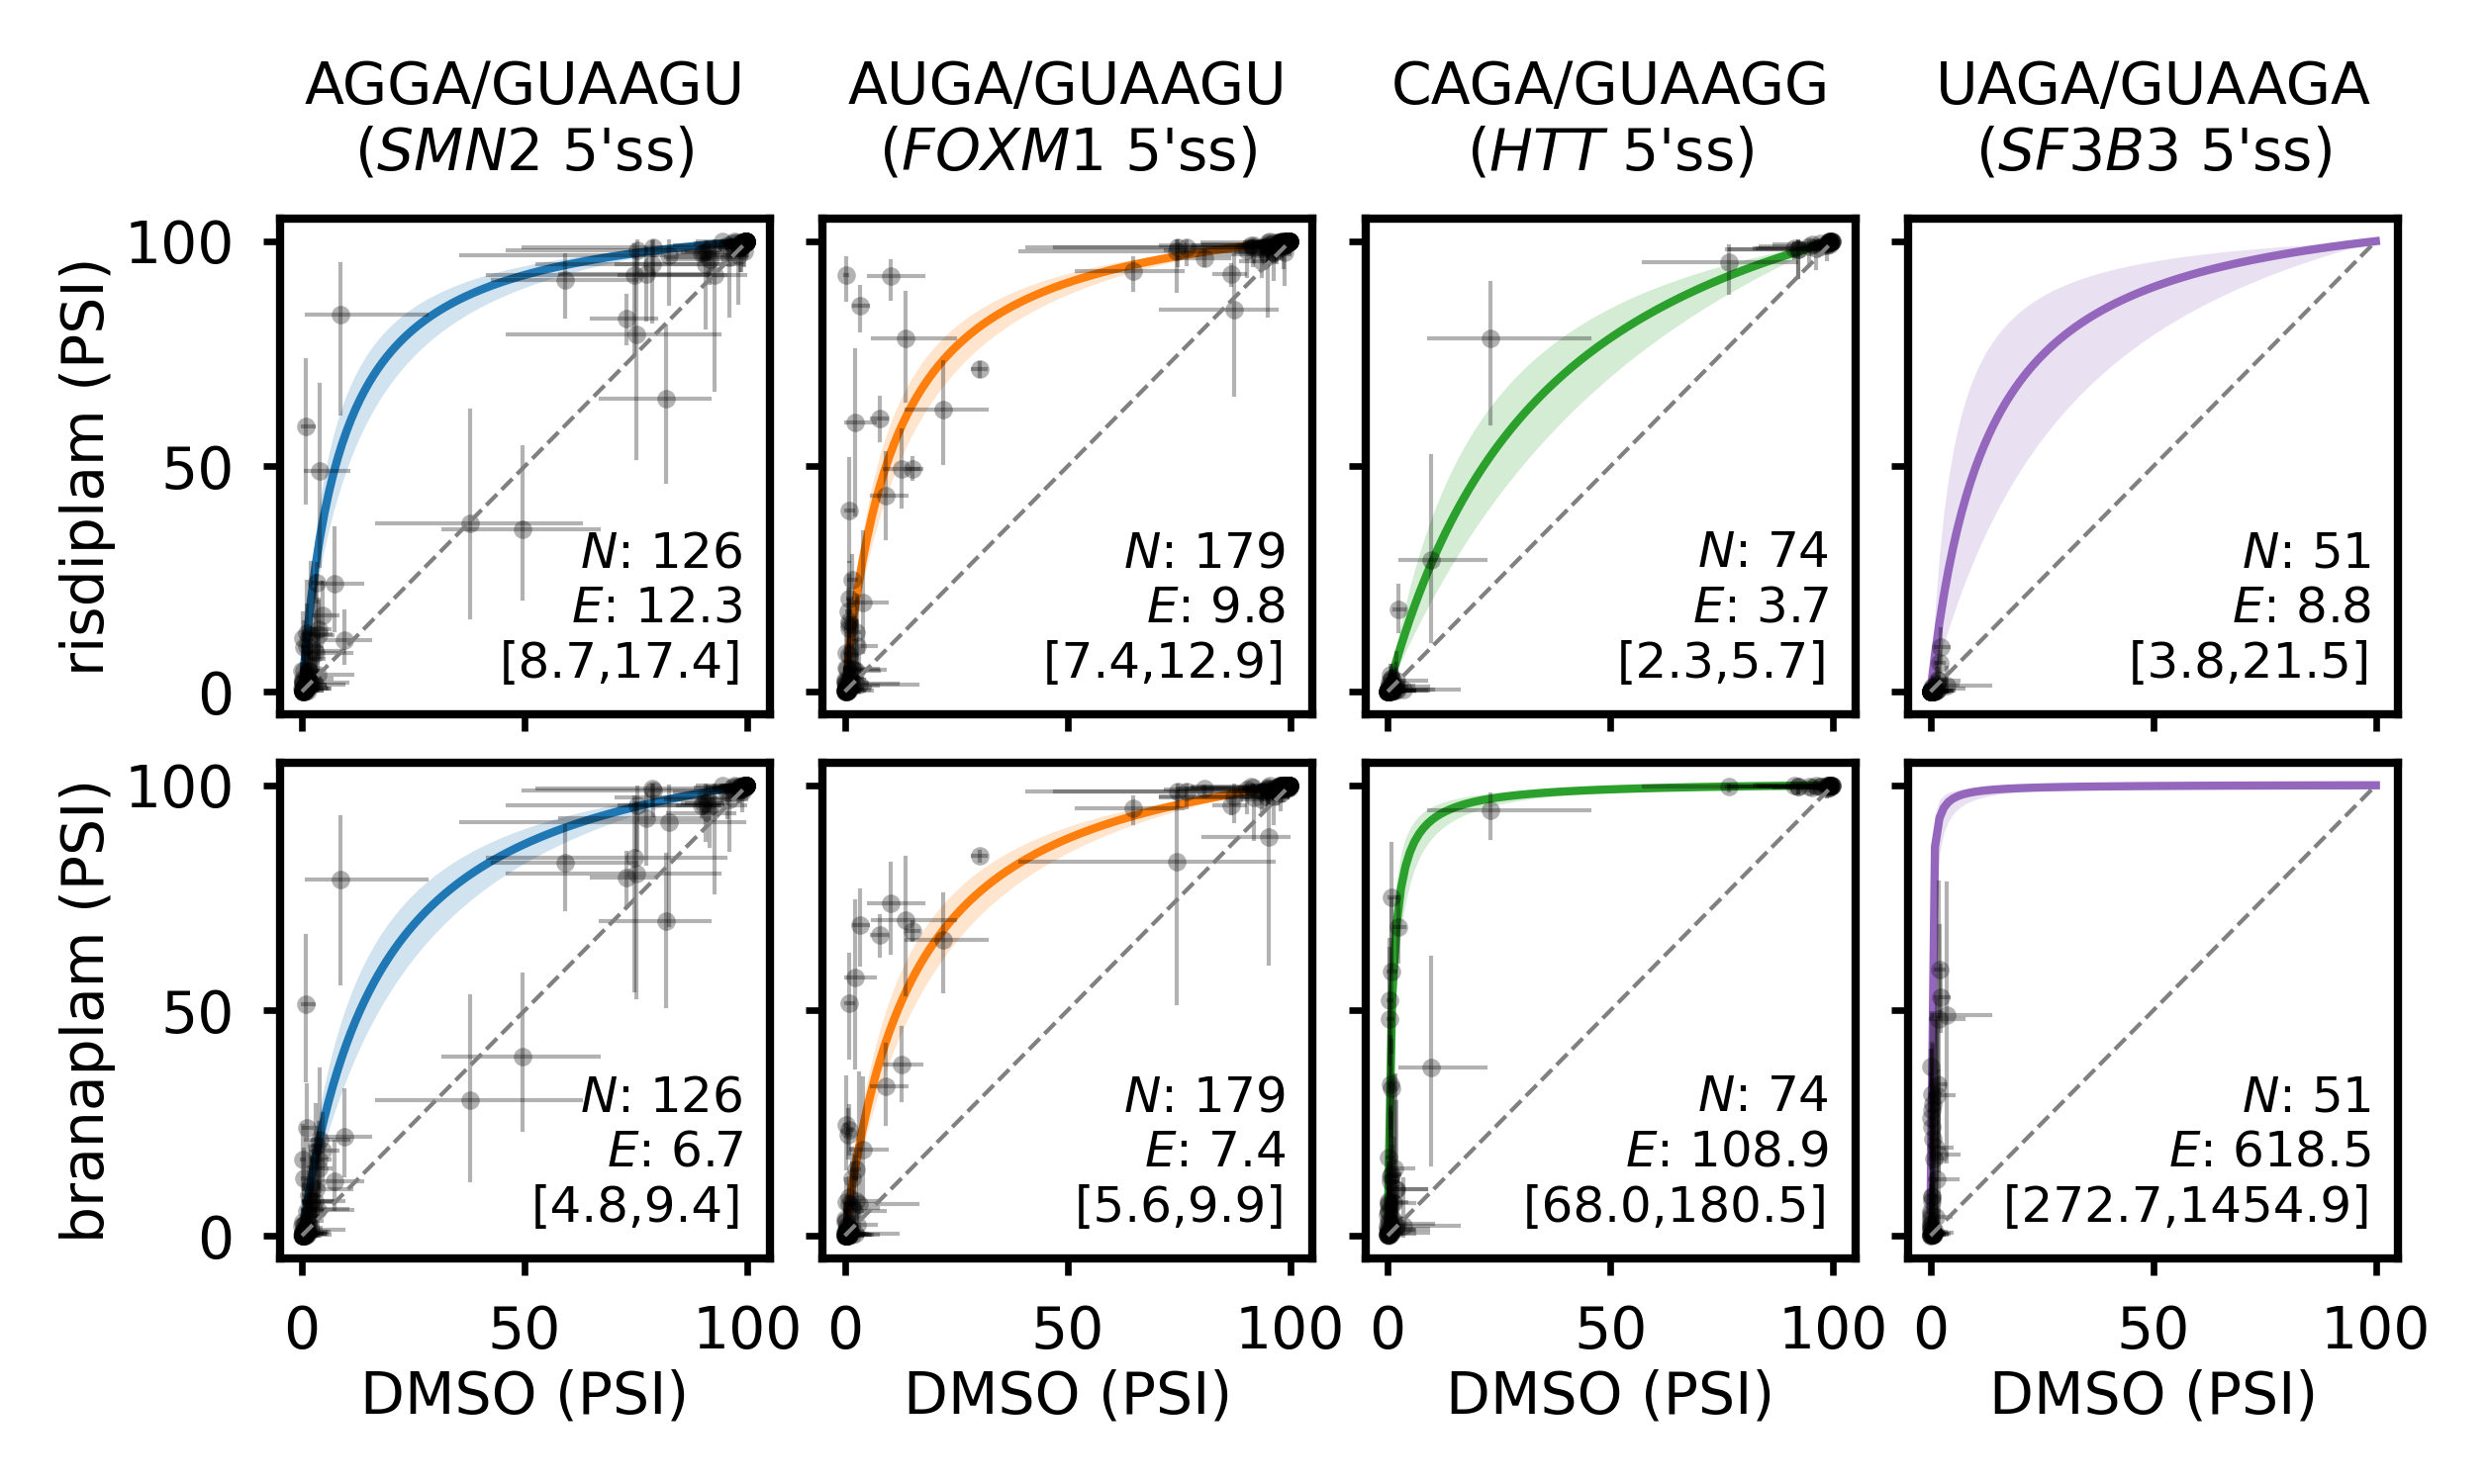

In [15]:
# Plot allelic manifolds
exon_dicts = [
    dict(motif='AGGA/GUAAGU', xytext=(30,6), text='$SMN2$ 5\'ss', relpos=[0,.5], shrinkB=2),
    dict(motif='AUGA/GUAAGU', xytext=(8,2), text='$FOXM1$ 5\'ss', relpos=[0,1], shrinkB=2),
    dict(motif='CAGA/GUAAGG', xytext=(9,100), text='$HTT$ 5\'ss', relpos=[0,.5], shrinkB=3),
    dict(motif='UAGA/GUAAGA', xytext=(22,550), text='$SF3B3$ 5\'ss', relpos=[0,.5], shrinkB=3)
]

seqs = [ed['motif'] for ed in exon_dicts]
loci = [ed['text'] for ed in exon_dicts]
colors = ['C0', 'C1', 'C2', 'C4']
fig, subplots = plot_manifolds(rmats_df, manifold_df, 
                               figsize=[4.0,2.3],
                               sel_seqs=seqs, 
                               loci=loci,
                               colors=colors,
                               plot_err=True)
fig.tight_layout(w_pad=0, h_pad=0.5, pad=0)
panel_name='E'
fig.savefig(f'fig2E.pdf')

In [16]:
# AAGAGUHNN
ix = (manifold_df['ct'] < 300) & np.array([re.match('AAGA/GU[^G]..',s) for s in manifold_df.index])
manifold_df[ix].sort_values(by='ct', ascending=False)[['risdiplam.beta','branaplam.beta','ct']].head(5)

,risdiplam.beta,branaplam.beta,ct
AAGA/GUAAGU,1.941390,2.403690,248
AAGA/GUAAGA,3.352947,5.618852,131
AAGA/GUAAGC,1.650240,4.122949,87
AAGA/GUAUGU,0.822263,2.261708,55
AAGA/GUAAGG,2.373174,4.186192,53


In [17]:
# ABGAGUHNN
ix = (manifold_df['ct'] < 300) & np.array([re.match('A[^A]GA/GU[^G]..',s) for s in manifold_df.index])
manifold_df[ix].sort_values(by='ct', ascending=False)[['risdiplam.beta','branaplam.beta','ct']].head(5)

,risdiplam.beta,branaplam.beta,ct
AUGA/GUAAGU,2.284513,2.006075,179
AGGA/GUAAGU,2.509836,1.896653,126
AUGA/GUAAGA,3.070788,3.274409,75
ACGA/GUAAGU,1.593346,1.250532,42
AGGA/GUAAGA,2.571567,2.166958,36


In [18]:
# BAGAGUHNN
ix = (manifold_df['ct'] < 300) & np.array([re.match('[^A]AGA/GU[^G]..',s) for s in manifold_df.index])
manifold_df[ix].sort_values(by='ct', ascending=False)[['risdiplam.beta','branaplam.beta','ct']].head(5)

,risdiplam.beta,branaplam.beta,ct
CAGA/GUAAGU,0.185426,2.238189,256
CAGA/GUAAGA,0.723089,4.010711,249
GAGA/GUAAGU,0.494228,3.852694,191
UAGA/GUAAGU,0.769618,3.870350,131
CAGA/GUAAGG,1.295221,4.690781,74


In [19]:
# NNGAGUGNN
ix = (manifold_df['ct'] < 300) & np.array([re.match('..AG/GU...',s) for s in manifold_df.index])
manifold_df[ix].sort_values(by='ct', ascending=False)[['risdiplam.beta','branaplam.beta','ct']].head(5)

,risdiplam.beta,branaplam.beta,ct
UCAG/GUAUGU,0.047462,0.170512,299
GCAG/GUAAGG,0.012998,-0.051171,293
GAAG/GUAAGG,-0.018324,-0.012544,288
CCAG/GUAAGU,-0.136685,-0.077575,285
AAAG/GUGAGA,0.056342,0.060048,285


### Supplemental figures

In [20]:
rmats_df.head()

,DMSO_PSI,DMSO_PSI_q0.025,DMSO_PSI_q0.975,Risdiplam_PSI,Risdiplam_PSI_q0.025,Risdiplam_PSI_q0.975,Branaplam_PSI,Branaplam_PSI_q0.025,Branaplam_PSI_q0.975,5ss
event_id,,,,,,,,,,
"chr21:46635673-46635763,46636438-46636547,46636895-46636990+",0.125568,0.103237,0.151840,0.103712,0.085447,0.125584,0.207828,0.176884,0.241491,CCAG/GUAGGG
"chr21:46636895-46636990,46643534-46643639,46644305-46644488+",0.998346,0.993276,0.999849,0.999851,0.999267,1.000000,0.999870,0.999272,1.000000,CCAG/GUAGCC
"chr21:46636895-46636990,46644305-46644488,46648457-46648538+",0.995459,0.976756,0.999671,0.995913,0.983073,0.999843,0.998385,0.992661,0.999950,UCUG/GUAUUG
"chr21:46648457-46648619,46649574-46649739,46660832-46660962+",0.996505,0.984109,0.999766,0.999742,0.998499,0.999999,0.999743,0.998568,0.999999,GCUG/GUGAGG
"chr21:46648457-46648619,46649574-46649739,46664294-46664473+",0.995359,0.970740,0.999843,0.997431,0.991316,0.999983,0.998480,0.994788,0.999990,GCUG/GUGAGG


161538
161145
162604
126
730


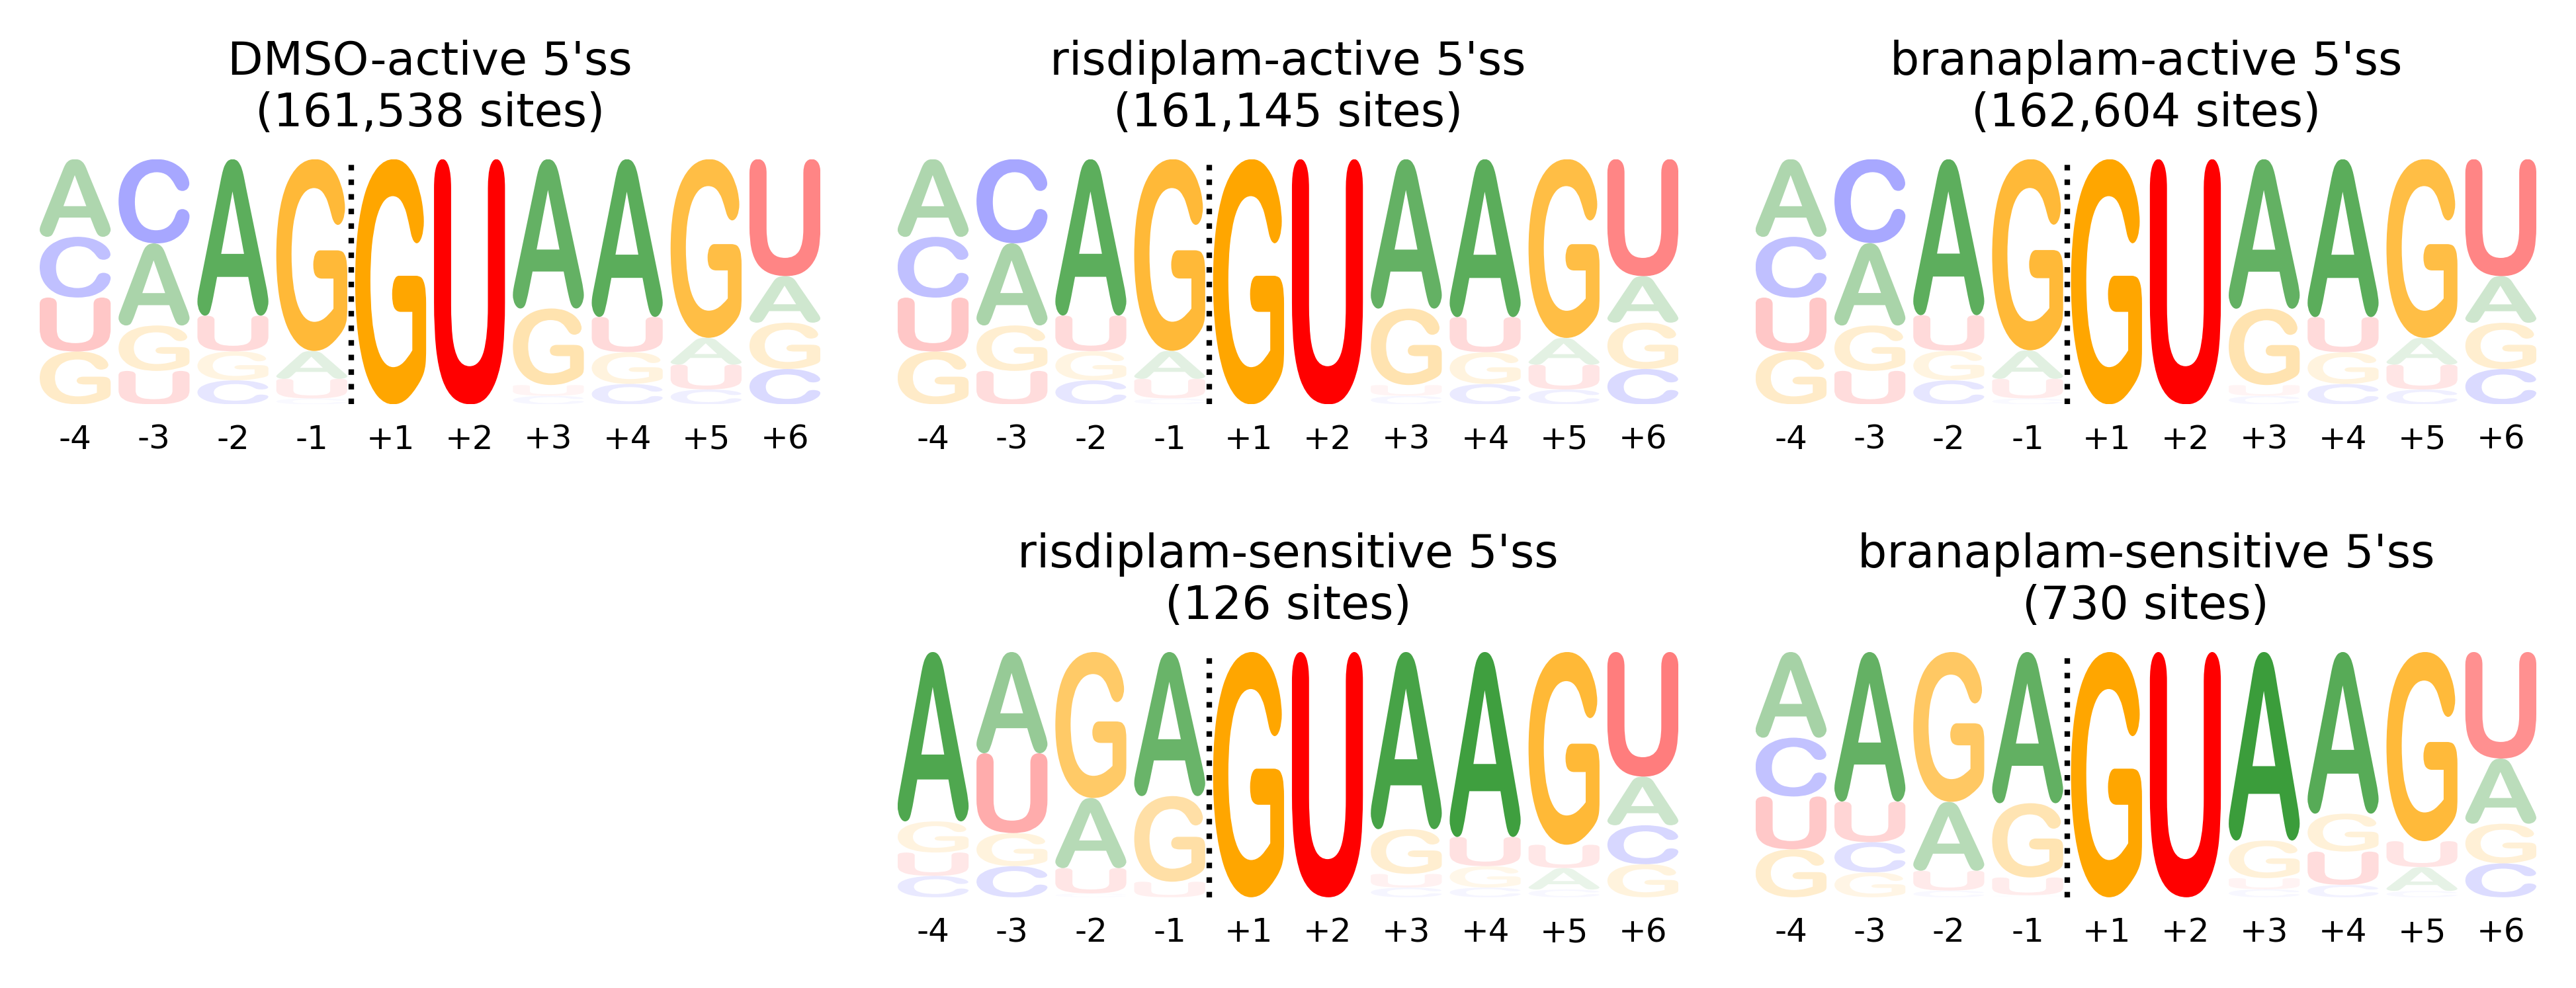

In [21]:
# Create figure
fig, axs = plt.subplots(2,3,figsize=[6.5,2.5], sharex=False)
axs = axs.ravel()
import pdb

# Function to draw probability logos
def draw(ix, ax, title='logo'):
    seqs = rmats_df['5ss'][ix]
    seqs = [s[:4] + s[-6:] for s in seqs]
    print(len(seqs))
    L = 10
    xticklabels = [f'{x:+d}' for x in range(-4,7) if not x==0]
    logo_mat = lm.alignment_to_matrix(seqs, to_type='probability', pseudocount=0)
    logo = lm.Logo(logo_mat, ax=ax, show_spines=False, baseline_width=0, 
                   font_name='Arial Rounded MT Bold', width=.9, fade_probabilities=True)
    ax.set_yticks([])
    ax.set_xticks(range(L))
    ax.set_xticklabels(xticklabels)
    ax.set_title(f'{title}\n({len(seqs):,d} sites)')
    ax.tick_params(length=0, labelsize=6)
    ax.axvline(3.5, linestyle=':', linewidth=1, color='k')
    
#     for pos,base in fixed_pos_base_tuples:
#         pos = pos+4 if pos < 0 else pos+3
#         logo.style_single_glyph(c=base, p=pos, color='k')

        
draw(ax = axs[0],
     ix = rmats_df['DMSO_PSI'] > 0.1,
     title = "DMSO-active 5'ss")

draw(ax = axs[1],
     ix = rmats_df['Risdiplam_PSI'] > 0.1,
     title = "risdiplam-active 5'ss")

draw(ax = axs[2],
     ix = rmats_df['Branaplam_PSI'] > 0.1,
     title = "branaplam-active 5'ss")

axs[3].set_visible(False)

def logit2(x):
    return np.log2(x/(1-x))

draw(ax = axs[4],
     ix = (logit2(rmats_df['Risdiplam_PSI']) - logit2(rmats_df['DMSO_PSI']) > 4) & (rmats_df['Risdiplam_PSI'] > .1) & (rmats_df['DMSO_PSI'] < .9),
     title = "risdiplam-sensitive 5'ss")

draw(ax = axs[5],
     ix = (logit2(rmats_df['Branaplam_PSI']) - logit2(rmats_df['DMSO_PSI']) > 4) & (rmats_df['Branaplam_PSI'] > .1) & (rmats_df['DMSO_PSI'] < .9),
     title = "branaplam-sensitive 5'ss")


fig.tight_layout(h_pad=2, w_pad=2)
fig.savefig(f'figS14.pdf')